### Lab 2: Hyponyms and Hypernyms

In [1]:
import pandas as pd
import wikipedia
import os
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
from IPython.display import display
import json
num_cores = multiprocessing.cpu_count()
print(num_cores)
wikipedia.set_lang("ru")
# DATA_PATH_LIST = ['D:','src2','taxonomy-enrichment','data','training_data']
DATA_PATH_LIST = ['.']
EMBEDDING_MODEL_FILENAME = "wiki_node2vec.bin"
DATA_PATH="/".join(DATA_PATH_LIST+["training_nouns.tsv"])
df = pd.read_csv(DATA_PATH,sep='\t')
%matplotlib inline

4


In [2]:
def prestr(x):
    return str(x).replace('\"','').replace("'",'"')

In [3]:
class DefDict(defaultdict):
    def __missing__(self, key):
        self[key] = key
        return key
    
idx2syns = DefDict(lambda x:x)
for val in df.values:
    idx2syns[val[0]]=val[1]
    try:
        pidxs = json.loads(prestr(val[2]))
        concp = [el.split(",")[0] for el in json.loads(prestr(val[3]))]
        idx2syns.update(dict(zip(pidxs,concp)))
    except:
        print(prestr(val[2]))
        print(prestr(val[3]))

### Interactive visualization of hyponyms and hypernyms

Button(description='Draw', style=ButtonStyle())

Text(value='МАТЬ', description='String:', placeholder='Query')

graphdraw МАТЬ
['ИГУМЕН МОНАСТЫРЯ', ' ИГУМЕНЬЯ МОНАСТЫРЯ', ' МАТЬ-ИГУМЕНЬЯ', ' ОТЕЦ-ИГУМЕН', ' ИГУМЕНЬЯ', ' ИГУМЕН']
['МОЛОЧНАЯ МАТЬ', ' КОРМИЛИЦА']
['СПОСОБНОСТЬ ПОНИМАТЬ ЗНАЧЕНИЕ СВОИХ ДЕЙСТВИЙ', ' ВМЕНЯЕМОСТЬ']
['СПОСОБНОСТЬ ПОНИМАТЬ ЗНАЧЕНИЕ СВОИХ ДЕЙСТВИЙ', ' ВМЕНЯЕМОСТЬ']
['СУРМАМА', ' СУРРОГАТНАЯ МАМА', ' СУРРОГАТНАЯ МАТЬ', ' СУРРОГАТНОЕ МАТЕРИНСТВО']
['СВЕКРОВЬ', ' МАТЬ МУЖА']
['МАТЬ ЖЕНЫ', ' ТЕЩА']


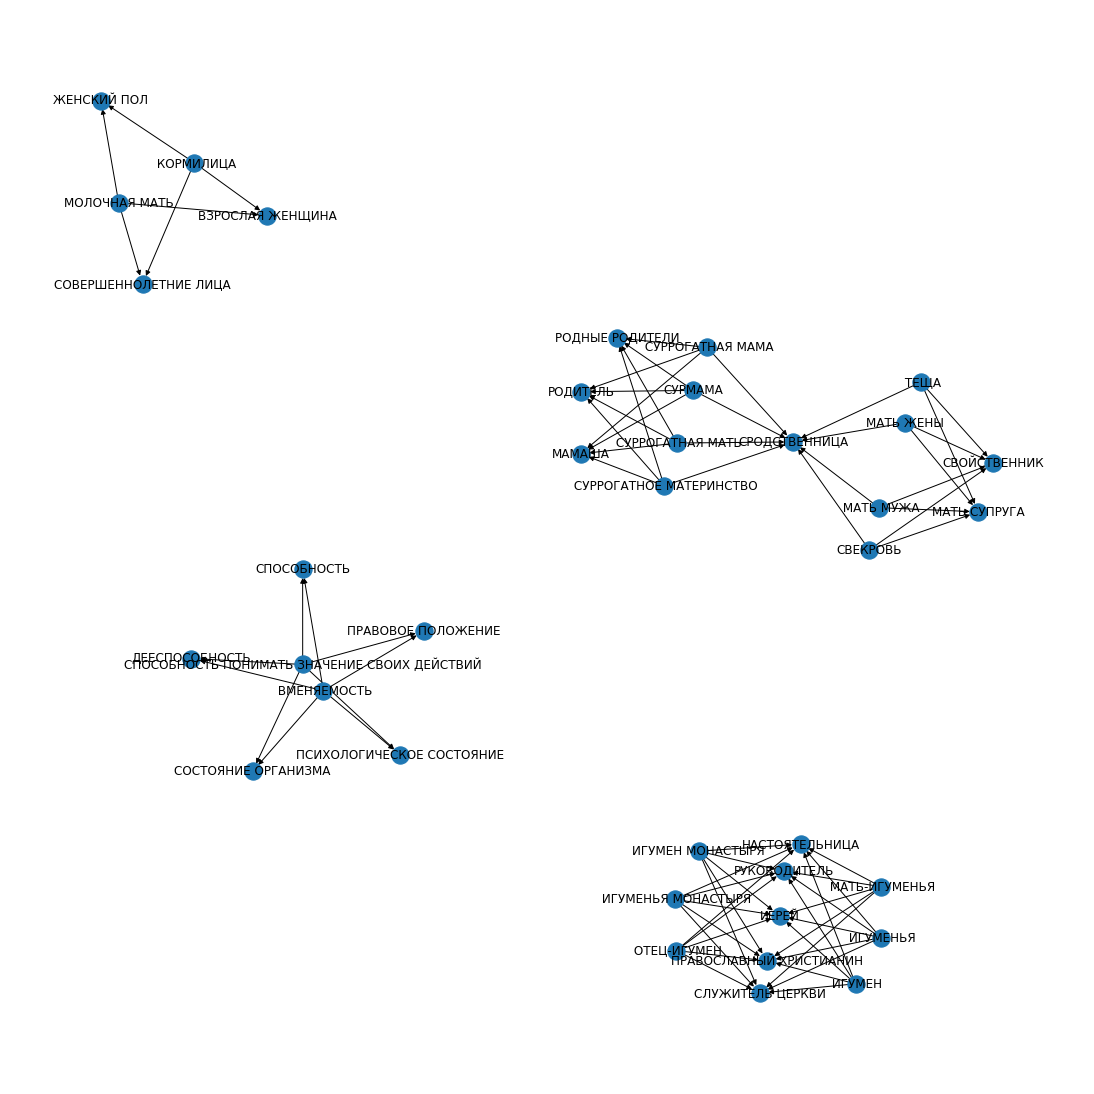

In [4]:
button = widgets.Button(description="Draw")
query = widgets.Text(
    value='МАТЬ',
    placeholder='Query',
    description='String:',
    disabled=False
)
display(button,query)




def creategraph(df):
    res = []
    for row in df.values:
        cohyps = row[1].split(",")
        for idx,cohyp in enumerate(cohyps):
            for parent in json.loads(prestr(row[2])):
                res.append((row[0]+'-'+str(idx),parent))
    return res

def graphdraw(b):
    print("graphdraw",query.value)
    subset = df[df['TEXT'].str.contains(query.value.upper())]
    g = nx.DiGraph()
    for el in subset.values:
        cohyps = el[1].split(",")
        print(cohyps)
        syns = idx2syns[el[0]]
        for child in cohyps:
            for parent in json.loads(prestr(el[2])):
                ed = g.add_edge(child,idx2syns[parent],label="is a")
            
    plt.figure(figsize=(15,15))
    pos = nx.nx_agraph.graphviz_layout(g)
    nx.draw(g,with_labels=True,pos=pos)
#     edge_labels=nx.draw_networkx_edge_labels(g,pos=pos)
    plt.show()
button.on_click(graphdraw)

### Pattern extractor

Yargy — библиотека для извлечения структурированной информации из текстов на русском языке. Правила описываются контекстно-свободными грамматиками и словарями ключевых слов. Банк готовых правил для имён, дат, адресов и других сущностей доступен в репозитории Natasha.
* https://yargy.readthedocs.io/ru/latest/
* http://pymorphy2.readthedocs.io/en/latest/user/grammemes.html
* https://github.com/natasha/natasha

### Токенизатор

In [5]:
from yargy.tokenizer import MorphTokenizer


tokenizer = MorphTokenizer()
text = '''Ростов-на-Дону
Длительностью 18ч. 10мин.
Яндекс.Такси
π ≈ 3.1415
1 500 000$
http://vk.com
'''
for line in text.splitlines():
    print([_.value for _ in tokenizer(line)])

['Ростов', '-', 'на', '-', 'Дону']
['Длительностью', '18', 'ч', '.', '10', 'мин', '.']
['Яндекс', '.', 'Такси']
['π', '≈', '3', '.', '1415']
['1', '500', '000', '$']
['http', ':', '/', '/', 'vk', '.', 'com']


# Газеттир
Газеттир нужен для удобной работы с последовательностью слов. Например, можно написать:

In [6]:
from yargy import or_, rule
from yargy.predicates import normalized

RULE = or_(
    rule(normalized('dvd'), '-', normalized('диск')),
    rule(normalized('видео'), normalized('файл'))
)

In [7]:
from yargy import Parser
from yargy.pipelines import morph_pipeline


RULE = morph_pipeline([
    'dvd-диск',
    'видео файл',
    'видеофильм',
    'газета',
    'электронный дневник',
    'эссе',
])

parser = Parser(RULE)
text = 'Видео файл на dvd-диске'
for match in parser.findall(text):
    print([_.value for _ in match.tokens])

['Видео', 'файл']
['dvd', '-', 'диске']


In [8]:
from yargy import Parser, rule, and_
from yargy.predicates import gram, is_capitalized, dictionary


GEO = rule(
    and_(
        gram('ADJF'),  # так помечается прилагательное, остальные пометки описаны в
                       # http://pymorphy2.readthedocs.io/en/latest/user/grammemes.html
        is_capitalized()
    ),
    gram('ADJF').optional().repeatable(),
    dictionary({
        'федерация',
        'республика'
    })
)


parser = Parser(GEO)
text = '''
В Чеченской республике на день рождения ...
Донецкая народная республика провозгласила ...
Башня Федерация — одна из самых высоких ...
'''
for match in parser.findall(text):
    print([_.value for _ in match.tokens])

['Чеченской', 'республике']
['Донецкая', 'народная', 'республика']


### Предикаты

Предикат — функция, которая принимает на вход токен и возвращает True или False. В Yargy встроено много готовых предикатов. Полный список есть в справочнике. Предикаты комбинируются с помощью and_, or_ и not_.

In [9]:
from yargy import and_, not_
from yargy.tokenizer import MorphTokenizer
from yargy.predicates import is_capitalized, eq


tokenizer = MorphTokenizer()
token = next(tokenizer('Стали'))

predicate = is_capitalized()
print(predicate(token))
print(token)
predicate = and_(
    is_capitalized(),
    not_(eq('марки'))
)
print(predicate(token))

True
MorphToken('Стали', [0, 5), 'RU', [Form('стать', Grams(VERB,indc,intr,past,perf,plur)), Form('сталь', Grams(NOUN,femn,gent,inan,sing)), Form('сталь', Grams(NOUN,datv,femn,inan,sing)), Form('сталь', Grams(NOUN,femn,inan,loct,sing)), Form('сталь', Grams(NOUN,femn,inan,nomn,plur)), Form('сталь', Grams(NOUN,accs,femn,inan,plur))])
True


### Грамматики
В Yargy используется специальный DSL для описания грамматик. Любую контекстно-свободную грамматику можно описать с помощью конструкций Питона. Например, есть примитивная грамматика для размеров одежды:

KEY -> р. | размер

VALUE -> S | M | L

SIZE -> KEY VALUE



In [10]:
from yargy import rule, or_


KEY = or_(
    rule('р', '.'),
    rule('размер')
).named('KEY')
VALUE = or_(
    rule('S'),
    rule('M'),
    rule('L'),
    rule('XS'),
).named('VALUE')
SIZE = rule(
    KEY,
    VALUE
).named('SIZE')
SIZE.normalized.as_bnf

SIZE -> KEY VALUE
KEY -> 'р' '.' | 'размер'
VALUE -> 'S' | 'M' | 'L' | 'XS'


In [11]:
parser = Parser(
    SIZE
)
text = 'размер M; размер A; размер XS;'
for match in parser.findall(text):
    print([_.value for _ in match.tokens])

['размер', 'M']
['размер', 'XS']


In [12]:
from yargy import Parser, rule, and_, or_, not_
from yargy.interpretation import fact, attribute
from yargy.predicates import gram, is_capitalized, dictionary, eq
import re
import pandas as pd
from tqdm import tqdm_notebook
from gensim import utils

In [13]:

START = rule(
    or_(
        rule(gram('ADJF')),
        rule(gram('NOUN'))
    ).optional(),
    gram('NOUN')
)

START_S = or_(
    eq('такой'),
    eq('такие'),
)

KAK = eq('как')
INCLUDING = or_(
    or_(
        eq('в'),
        eq('том'),
        eq('числе'),
    ),
    eq('включающий'),
    or_(
        eq('включающий'),
        eq('в'),
        eq('себя'),
    ),
    or_(
        eq('включающие'),
        eq('в'),
        eq('себя'),
    ),
    eq('включающие'),
    eq('особенно'),

)

MID_S = or_(
    rule(
        or_(
            eq('такой'),
            eq('такие'),
        ),
        eq('как')
    )
)
ATAKJE = rule(
    eq(','),
    eq('а'),
    eq('также')
)

MID = or_(
    rule(
        eq('это')
    ),
    rule(
        eq('—')
    ),
    rule(
        eq('—'),
        eq('это')
    ),
    rule(
        eq('—'),
        not_(eq('км'))
    ),
    rule(
        eq('-'),
        eq('это')
    ),    
    rule(
        eq('являются')
    ),
    rule(
        eq('является')
    ),
    rule(
        or_(
            eq('и'),
            eq('или'),
        ),
        eq('другие')
    )
)

END = or_(
    rule(
        gram('NOUN'),
        gram('NOUN')
    ),
    rule(
        gram('ADJF').repeatable(),
        gram('NOUN')
    ),
    rule(
        gram('ADJF'),
        gram('ADJF').repeatable(),
        gram('NOUN')
    ),
    rule(
        gram('NOUN').repeatable(),
        gram('ADJF'),
        gram('NOUN').repeatable()
    ),
    rule(
        gram('NOUN').repeatable()
    )
)

Item = fact(
    'Item',
    [attribute('titles').repeatable()]
)


IGNORE = rule(
    '(',
    not_(eq(')')).repeatable(),
    ')'
)

ITEM = rule(
    IGNORE.interpretation(
        Item.titles
    ),
    eq(',').optional() 
).repeatable().interpretation(
    Item
)

In [16]:
def get_hyperonyms(main_word):
    HYPONYM = eq(utils.deaccent(main_word))
    RULE = or_(
        rule(HYPONYM, ATAKJE, START, MID, END),
        rule(HYPONYM, MID, END),
        rule(HYPONYM, MID, MID, END),
        rule(START_S, END, KAK, HYPONYM),
        rule(END, INCLUDING, HYPONYM),
        rule(HYPONYM, END)
    )
    parser = Parser(RULE) 
    text = utils.deaccent(wikipedia.summary(main_word))
    print(text)
    text = re.sub(r'\(.+?\)', '', text)
    text = text.lower().replace('* сергии радонежскии* ', '')
    for idx, match in enumerate(parser.findall(text.lower())):
        k = [_.value for _ in match.tokens]
        print(k)

In [17]:
get_hyperonyms("банан")

Банан — название съедобных плодов культивируемых растении рода Банан (Musa); обычно под таковыми понимают Musa acuminata и Musa × paradisiaca, а также Musa balbisiana, Musa fehi, Musa troglodytarum и ряд других. Также бананами могут называть плоды Ensete ventricosum (строго говоря, являющегося представителем другого рода семеиства Банановые). С ботаническои точки зрения банан является ягодои, многосеменнои и толстокожеи. У культурных форм часто отсутствуют семена, ненужные при вегетативном размножении. Плоды имеют длину 6—30 см и диаметр 2—5 см. Соплодия могут состоять из 300 плодов и иметь массу до 50—60 кг.
Бананы — одна из древнеиших пищевых культур, а для тропических стран важнеишее пищевое растение и главная статья экспорта. Спелые бананы широко употребляются в пищу по всему миру, их используют при приготовлении большого количества блюд. Помимо употребления в свежем виде, в кухне некоторых народов бананы могут зажариваться, или вариться как в очищенном, так и в неочищенном виде. И

#### Task 1 (deadline 19.02.2020 24:00)
* Find your name on the spreadsheet https://docs.google.com/spreadsheets/d/1RR2I6toCkebbGU1UK83HS70Ru_l0_o-nnZIHyiFB0No/edit?usp=sharing. In opposite of your name there are 24 words of hyponyms, you have to insert five corresponding hypernyms next to them. Examples of hyponyms and hyperonyms relationship you can find above in the current Jupiter notebook.
* Find for each pair of hyponyms and hypernyms a corresponding snippet of a text with their mentions. The source of the text can be any free resources, e.g., Wikipedia, Google, Yandex, others. You should save the snippets and their URLs within the lab2 folder in your NLP git-repo with .csv file-extension in a single file.

#### Task 2 (deadline 26.02.2020 24:00)
* It would be best if you created a pandas DataFrame of the texts from the previous task. And apply to the DataFrame the function 'get_hyperonyms,' which must return the list of the corresponding hypernyms from the text automatically. If there are errors or misses, you should fix them in the code for your case of the 24 words. Nevertheless, it is strictly prohibited to use hard coding. Save your notebook with parser code within the lab2 folder in your NLP git-repo.

In [40]:
def get_hyper(row):
    main_word = row['word']
    text = row['text']
    
    HYPONYM = eq(utils.deaccent(main_word.lower()))
    RULE = or_(
        rule(HYPONYM, ATAKJE, START, MID, END),
        rule(HYPONYM, MID, END),
        rule(HYPONYM, MID, MID, END),
        rule(START_S, END, KAK, HYPONYM),
        rule(END, INCLUDING, HYPONYM),
        rule(HYPONYM, END),
        rule(END, MID, END),
        rule(END, MID, MID, END),
    )
    parser = Parser(RULE) 
    text = utils.deaccent(text)
    # print(text)
    text = re.sub(r'\(.+?\)', '', text)
    text = text.lower().replace('* сергии радонежскии* ', '')
    hyps = []
    for idx, match in enumerate(parser.findall(text.lower())):
        k = [_.value for _ in match.tokens]
        hyps.append(k)
    print(main_word, hyps)
    return hyps

In [15]:
tx = '''
Банан — название съедобных плодов культивируемых растении рода Банан (Musa); обычно под таковыми понимают Musa acuminata и Musa × paradisiaca, а также Musa balbisiana, Musa fehi, Musa troglodytarum и ряд других. Также бананами могут называть плоды Ensete ventricosum (строго говоря, являющегося представителем другого рода семеиства Банановые). С ботаническои точки зрения банан является ягодои, многосеменнои и толстокожеи. У культурных форм часто отсутствуют семена, ненужные при вегетативном размножении. Плоды имеют длину 6—30 см и диаметр 2—5 см. Соплодия могут состоять из 300 плодов и иметь массу до 50—60 кг.
Бананы — одна из древнеиших пищевых культур, а для тропических стран важнеишее пищевое растение и главная статья экспорта. Спелые бананы широко употребляются в пищу по всему миру, их используют при приготовлении большого количества блюд. Помимо употребления в свежем виде, в кухне некоторых народов бананы могут зажариваться, или вариться как в очищенном, так и в неочищенном виде. Их также сушат, консервируют, используют для приготовления банановои муки, мармелада, сиропов, вин. Бананы применяются также в качестве корма для скота. Запах бананов определяют изовалерианово-изоамиловыи и уксусно-изоамиловыи эфиры. Выращиваются в тропических и субтропических раионах с жарким влажным климатом. Существует большое число сортов съедобных видов банана.
Размер, цвет и форма могут значительно различаться в зависимости от вида или сорта, но чаще всего они имеют продолговатую цилиндрическую или трехгранную форму, выпрямленную либо закругленную. Длина плода варьирует в пределах от 3 до 40 см, толщина — от 2 до 8 см. Цвет кожицы может быть желтым, зеленым, красным или даже серебристым. Мякоть белая, кремовая, желтая или оранжевая. В незрелом состоянии она твердая и клеикая, но по мере созревания становится мягкои и сочнои.
Во многих странах бананы являются одним из основных источников питания — например, только в Эквадоре годовое потребление этого продукта составляет 73,8 кг на душу населения (для сравнения, в России этот показатель равен 7,29 кг). Существенную долю потребления бананы также составляют в Бурунди (189,4 кг), Самоа (85,0 кг), Коморских Островах (77,8 кг) и на Филиппинах (40,6 кг).
'''
drow = {'word':'банан',
       'text':tx}
get_hyper(drow)

NameError: name 'get_hyper' is not defined

In [17]:
import pandas as pd

data = pd.read_csv('sultan_apsalyamov_wordset.csv')
data.head()

,word,hyperonym,text,url
0,КНУТ,орудие,Орудие — инструмент вообще.\nРазвитие общества...,https://kartaslov.ru/%D0%B7%D0%BD%D0%B0%D1%87%...
1,КНУТ,наказание,Наказание — это мера государственного принужде...,https://kartaslov.ru/%D0%B7%D0%BD%D0%B0%D1%87%...
2,КНУТ,рыба,На мелководье у самого берега хорошо видны в п...,https://kartaslov.ru/%D0%B7%D0%BD%D0%B0%D1%87%...
3,КНУТ,угроза,"Обещание причинить какое-л. зло, неприятность....",https://kartaslov.ru/%D0%B7%D0%BD%D0%B0%D1%87%...
4,КНУТ,фамилия,"Дональд Эрвин Кнут (англ. Donald Ervin Knuth, ...",https://ru.wikipedia.org/wiki/%D0%9A%D0%BD%D1%...


In [42]:
data['dec_hyper'] = data.apply(lambda row: get_hyper(row), axis=1)

КНУТ [['орудие', '—', 'инструмент'], ['производство', 'орудии', 'труда', '—', 'процесс', 'коллективныи'], ['которыи', 'является', 'его', 'важнеишим']]
КНУТ [['наказание', '—', 'это', 'мера', 'государственного', 'принуждения'], ['цель', 'наказания', '—', 'побудить', 'человека'], ['кнут', 'палача']]
КНУТ [['бычок', '—', 'молодои', 'домашнии', 'бык']]
КНУТ [['угроза', '—', 'запугивание'], ['андрюшка', 'разметнов', '—', 'этот', 'рыском']]
КНУТ [['дональд', 'эрвин', 'кнут', '—', 'американскии', 'ученыи', 'в', 'области', 'информатики']]
КНЯЖЕНИЕ [['власть', '—', 'это', 'возможность'], ['политическая', 'власть', '—', 'способность', 'определеннои', 'социальнои', 'группы'], ['элементом', 'политическои', 'власти', 'является', 'государство', 'и', 'система', 'государственных', 'органов'], ['княжение', 'это', 'историческии']]
КНЯЖЕНИЕ [['управление', '—', 'деятельность', 'субъекта'], ['управление', '—', 'структурное', 'подразделение', 'в', 'организации'], ['управление', '—', 'синоним', 'понятия', '

In [14]:
# New rules

ISARE = or_(
    rule(
        eq('это')
    ),
    rule(
        eq('—')
    ),
    rule(
        eq('—'),
        eq('это')
    ),
    rule(
        eq('—'),
        not_(eq('км'))
    ),
    rule(
        or_(
            eq('и'),
            eq('или'),
        ),
        eq('другие')
    )
)


ADJP = or_(
    rule(
        gram('ADJF').repeatable(1,3).optional(),
        gram('PREP').optional(),
        gram('PRTF').repeatable(1,3).optional(),
    )
)

NP = rule(
        ADJP.optional().repeatable(1,6),
        gram('NOUN')
    )


NOUNPHRASE = or_(
    rule(
        gram('ADJF').repeatable().optional(),
        gram('PRTF').repeatable().optional(),
        gram('NOUN')

    )
)

In [24]:
def new_get_hyper(row):
    main_word = row['word']
    text = row['text']
    
    HYPONYM = eq(utils.deaccent(main_word.lower()))
    RULE = or_(
        rule(HYPONYM, ISARE, NP)
    )
    parser = Parser(RULE) 
    text = utils.deaccent(text)
    # print(text)
    text = re.sub(r'\(.+?\)', '', text)
    text = text.lower().replace('* сергии радонежскии* ', '')
    hyps = []
    for idx, match in enumerate(parser.findall(text.lower())):
        k = [_.value for _ in match.tokens]
        hyps.append(k)
    print(main_word, hyps)
    return hyps

In [22]:
data['dec_hyper'] = data.apply(lambda row: new_get_hyper(row), axis=1)

КНУТ []
КНУТ []
КНУТ []
КНУТ []
КНУТ [['кнут', '—', 'американский', 'учёный', 'в', 'области']]
КНЯЖЕНИЕ []
КНЯЖЕНИЕ [['княжение', 'это', 'процесс']]
КНЯЖЕНИЕ []
КНЯЖЕНИЕ []
КНЯЖЕНИЕ [['княжение', 'это', 'состояние']]
КОБЗА []
КОБЗА []
КОБЗА []
КОБЗА []
КОБЗА []
КОБЗАРЬ []
КОБЗАРЬ []
КОБЗАРЬ []
КОБЗАРЬ []
КОБЗАРЬ []
КОВРИЖКА [['коврижка', '—', 'плоское', 'и']]
КОВРИЖКА [['коврижка', '—', 'изделие', 'из', 'пряничного', 'теста']]
КОВРИЖКА [['коврижка', '—', 'плоское', 'и']]
КОВРИЖКА [['коврижка', '—', 'изделие', 'из', 'пряничного', 'теста']]
КОВРИЖКА [['коврижка', '—', 'изделие', 'из', 'пряничного', 'теста']]
КОВЫЛЬ [['ковыль', '—', 'род', 'многолетних', 'однодольных', 'травянистых', 'растений']]
КОВЫЛЬ [['ковыль', '—', 'род', 'многолетних', 'однодольных', 'травянистых', 'растений']]
КОВЫЛЬ [['ковыль', '—', 'род', 'многолетних', 'однодольных', 'травянистых', 'растений']]
КОВЫЛЬ [['ковыль', '—', 'род', 'многолетних', 'однодольных', 'травянистых', 'растений']]
КОВЫЛЬ []
КОЖГАЛАНТЕРЕЯ []
КОЖ

In [21]:
def new_with_get_hyper(row):
    main_word = row['word']
    text = row['text']
    
    HYPONYM = eq(main_word.lower())
    RULE = or_(
        rule(HYPONYM, ISARE, NP)
    )
    parser = Parser(RULE) 
    
    # print(text)
    text = re.sub(r'\(.+?\)', '', text)
    text = text.lower().replace('* сергии радонежскии* ', '')
    hyps = []
    for idx, match in enumerate(parser.findall(text.lower())):
        k = [_.value for _ in match.tokens]
        hyps.append(k)
    print(main_word, hyps)
    return hyps

In [23]:
data['dec_hyper'] = data.apply(lambda row: new_with_get_hyper(row), axis=1)

КНУТ []
КНУТ []
КНУТ []
КНУТ []
КНУТ [['кнут', '—', 'американский', 'учёный', 'в', 'области']]
КНЯЖЕНИЕ []
КНЯЖЕНИЕ [['княжение', 'это', 'процесс']]
КНЯЖЕНИЕ []
КНЯЖЕНИЕ []
КНЯЖЕНИЕ [['княжение', 'это', 'состояние']]
КОБЗА []
КОБЗА []
КОБЗА []
КОБЗА []
КОБЗА []
КОБЗАРЬ []
КОБЗАРЬ []
КОБЗАРЬ []
КОБЗАРЬ []
КОБЗАРЬ []
КОВРИЖКА [['коврижка', '—', 'плоское', 'и']]
КОВРИЖКА [['коврижка', '—', 'изделие', 'из', 'пряничного', 'теста']]
КОВРИЖКА [['коврижка', '—', 'плоское', 'и']]
КОВРИЖКА [['коврижка', '—', 'изделие', 'из', 'пряничного', 'теста']]
КОВРИЖКА [['коврижка', '—', 'изделие', 'из', 'пряничного', 'теста']]
КОВЫЛЬ [['ковыль', '—', 'род', 'многолетних', 'однодольных', 'травянистых', 'растений']]
КОВЫЛЬ [['ковыль', '—', 'род', 'многолетних', 'однодольных', 'травянистых', 'растений']]
КОВЫЛЬ [['ковыль', '—', 'род', 'многолетних', 'однодольных', 'травянистых', 'растений']]
КОВЫЛЬ [['ковыль', '—', 'род', 'многолетних', 'однодольных', 'травянистых', 'растений']]
КОВЫЛЬ []
КОЖГАЛАНТЕРЕЯ []
КОЖ